## Import package

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [203]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr

## Loading Data

In [5]:
dic_path = "/Users/peterlin0629/Course/personal practice/Twitch"

In [7]:
df = pd.read_csv(dic_path + "/twitchdata-update.csv")

## Exploration 

In [9]:
#Check if all 1000 top players are recorded
df.shape

(1000, 11)

In [16]:
# take a look at the features we have
df.columns.values

array(['Channel', 'Watch time(Minutes)', 'Stream time(minutes)',
       'Peak viewers', 'Average viewers', 'Followers', 'Followers gained',
       'Views gained', 'Partnered', 'Mature', 'Language'], dtype=object)

In [21]:
# check if there is missing value
df.isnull().sum()

Channel                 0
Watch time(Minutes)     0
Stream time(minutes)    0
Peak viewers            0
Average viewers         0
Followers               0
Followers gained        0
Views gained            0
Partnered               0
Mature                  0
Language                0
dtype: int64

In [22]:
df.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English


### Language 

In [34]:
len(df["Language"].unique())
# 21 different language

21

In [180]:
# interested in number of channels and followers of each language
lan_bar_df = df.groupby("Language").agg({"Channel":"count","Followers":"sum"})
lan_bar_df = lan_bar_df.rename(columns={"Channel":"Channel_count"})\
.sort_values("Channel_count", ascending = False).reset_index() 

In [181]:
lan_bar_df["Channel_percentage"] = lan_bar_df["Channel_count"]/1000*100
total_followers = df["Followers"].sum()
lan_bar_df["Follower_percentage"] = lan_bar_df["Followers"]/total_followers*100

In [182]:
lan_bar_df.head()

,Language,Channel_count,Followers,Channel_percentage,Follower_percentage
0,English,485,342257538,48.5,60.039487
1,Korean,77,20187388,7.7,3.541311
2,Russian,74,25140056,7.4,4.410118
3,Spanish,68,53018656,6.8,9.300636
4,French,66,29022481,6.6,5.091180


Text(0.5, 1.0, 'number of followers')

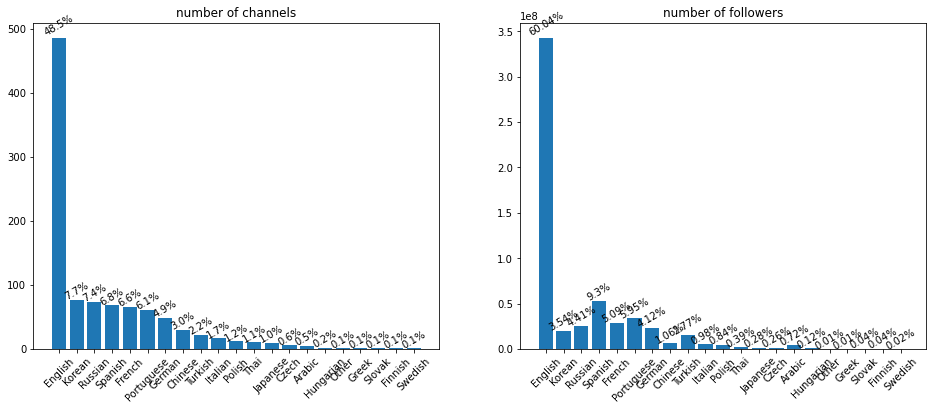

In [185]:
plt.figure(1, figsize=(16,6))


# bar chart for number of channels in each language 
plt.subplot(121)
graph = plt.bar(lan_bar_df.Language, lan_bar_df.Channel_count)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
      
    plt.text(x+width/2, y+height*1.01,
             str(round(lan_bar_df.Channel_percentage[i],2))+'%',
             ha='center', rotation = 30)
    i += 1
plt.xticks(rotation = 45)
plt.title("number of channels")

# bar chart for number of followers in each language 
plt.subplot(122)
graph = plt.bar(lan_bar_df.Language, lan_bar_df.Followers)

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
      
    plt.text(x+width/2, y+height*1.01,
             str(round(lan_bar_df.Follower_percentage[i],2))+'%',
             ha='center', rotation = 30)
    i += 1
plt.xticks(rotation = 45)
plt.title("number of followers")


#### English channel and followers dominate the platform. 
There are also some interested fact, some languages ranked on the top 5 actually have fewer followers than the lower ranked languages, which indicate relatively more streamer are streaming on the platform while the audience pool is actually smaller tham other languages, to be short, more competitive. This could be done by calculating average followers per language. 

In [186]:
lan_bar_df["Avg_Followers"] = lan_bar_df["Followers"] / lan_bar_df["Channel_count"]

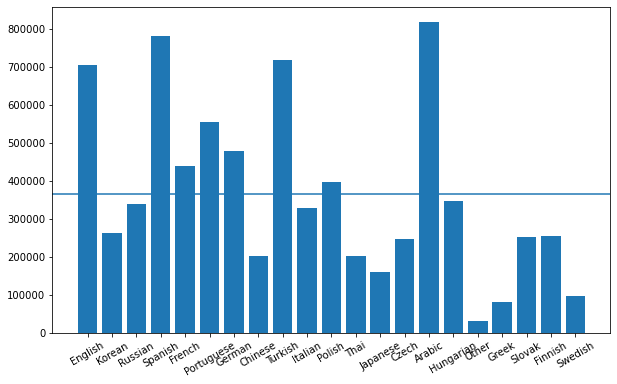

In [190]:
plt.figure(2, figsize=(10,6))
plt.bar(lan_bar_df.Language, lan_bar_df.Avg_Followers)
plt.xticks(rotation = 30)
plt.axhline(y=lan_bar_df.Avg_Followers.mean())

#### Blue horizontal line is the mean of average followers per channel of all languages     
Those belowe the line indicates more competitive market

### Which language channels performe better? 

The longer the streaming time and the more follower one channel has, the longer the watch time.      
Thus, we need to define some other matrices       






#### Define matrices
1. Trying **"avg watch time per viwer"** 

I first tried using **Watch time(Minutes) / Average viewers** to generate the **avg watch time per viwer.**       
But soon realize it is not the actual "avg watch time per viwer", if Watch time(Minutes) is calculated by sum of viewer per min and Average viewers is caluclated on a per min bases, the result should be clsoe to "Stream time(minutes)" instead.

In [73]:
df["avg_watchtime_per_viwer"] = df["Watch time(Minutes)"] / df["Average viewers"]
df["ratio"] = df["avg_watchtime_per_viwer"] / df["Stream time(minutes)"]

(array([  5., 461., 475.,  34.,  15.,   5.,   1.,   1.,   1.,   2.]),
 array([0.59553164, 0.81092775, 1.02632386, 1.24171997, 1.45711608,
        1.67251219, 1.8879083 , 2.1033044 , 2.31870051, 2.53409662,
        2.74949273]),
 <a list of 10 Patch objects>)

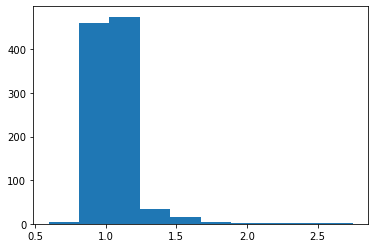

In [74]:
plt.hist(df["ratio"])

**Result**      
Turn out it's true that "Watch time(Minutes) / Average viewers" is close to "Stream time(minutes)"     
However, there are Channels with ratio far away from 1, and value > 1 is not reasonable, which is something I would like to further investigate, but not my first priority. 


In [75]:
df = df.drop(columns = ["avg_watchtime_per_viwer","ratio"])

2. Generate other matrices      
**AF Ratio = Average viewers/Followers** : How many percentage of followers are actively viewing      
**Coversion Rate = Followers gained / Views gained** : How many views gained actually convert into Followers

In [78]:
df["AF_Ratio"] = df["Average viewers"] / df["Followers"]
df["Coversion_Rate"] = df["Followers gained"] / df["Views gained"]

#### Filter out language with small sample size (<30)

In [132]:
large_sample_language = lan_bar_df["Language"][lan_bar_df["Channel_count"] >= 30]

In [142]:
df_filter =  df[df["Language"].isin(large_sample_language.values)]

In [144]:
df_filter.shape

(910, 13)

In [167]:
df_filter_agg = df_filter.groupby("Language").agg({"AF_Ratio":"mean","Coversion_Rate":"mean"})

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

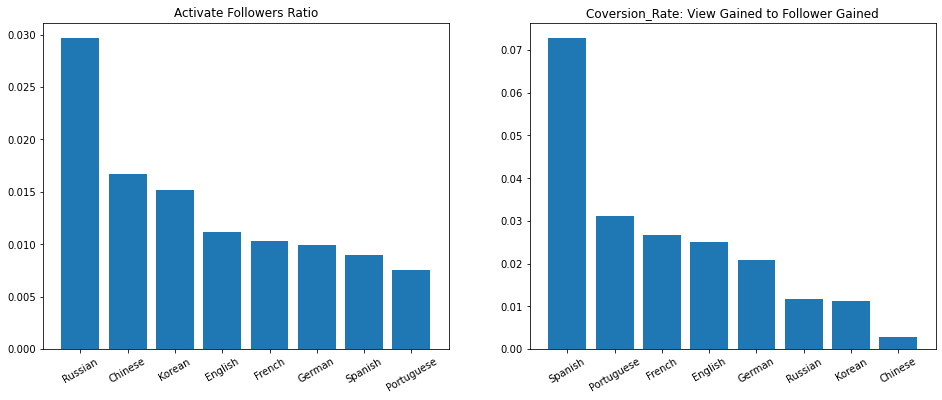

In [169]:
plt.figure(3, figsize=(16,6))

# bar chart for number of channels in each language 
plt.subplot(121)
graph = plt.bar(df_filter_agg.sort_values("AF_Ratio",ascending = False).index, 
                df_filter_agg.sort_values("AF_Ratio",ascending = False)["AF_Ratio"])
plt.title("Activate Followers Ratio")
plt.xticks(rotation = 30)

plt.subplot(122)
graph = plt.bar(df_filter_agg.sort_values("Coversion_Rate",ascending = False).index, 
                df_filter_agg.sort_values("Coversion_Rate",ascending = False)["Coversion_Rate"])
plt.title("Coversion_Rate: View Gained to Follower Gained")
plt.xticks(rotation = 30)

### ANOVA Test: is language really a factor influencing these two matrices?

In [ ]:
df_filter_agg

In [193]:
model = ols('AF_Ratio ~ Language', data=df_filter).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Language,0.026669,7.0,5.489539,0.000003
Residual,0.625998,902.0,NaN,NaN


In [194]:
model2 = ols('Coversion_Rate ~ Language', data=df_filter).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)
anova_table2

,sum_sq,df,F,PR(>F)
Language,0.199783,7.0,25.864072,2.290223e-32
Residual,0.995337,902.0,NaN,NaN


#### From statistical view, language is a factor that affects both  AF_ratio and Coversion_Rate

### Mature & Partnered 

The analysis of Language could be applied to these two features with some little adjuesment. I will skip it for now.

### Stream Time

Text(0, 0.5, 'Followers Gained')

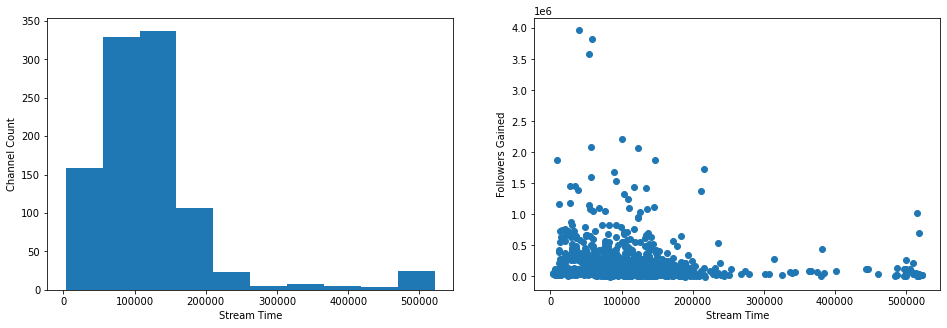

In [202]:
plt.figure(4, figsize=(16,5))

plt.subplot(121)
plt.hist(df["Stream time(minutes)"])
plt.xlabel("Stream Time")
plt.ylabel("Channel Count")

plt.subplot(122)
plt.scatter(df["Stream time(minutes)"], df["Followers gained"])
plt.xlabel("Stream Time")
plt.ylabel("Followers Gained")

#### Seems there is no strong relationship between Stream Time and Followers Gained

In [204]:
# calculate Pearson's correlation
corr, _ = pearsonr(df["Stream time(minutes)"], df["Followers gained"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.158


#### Even a negative correlation

### All possbile correlation

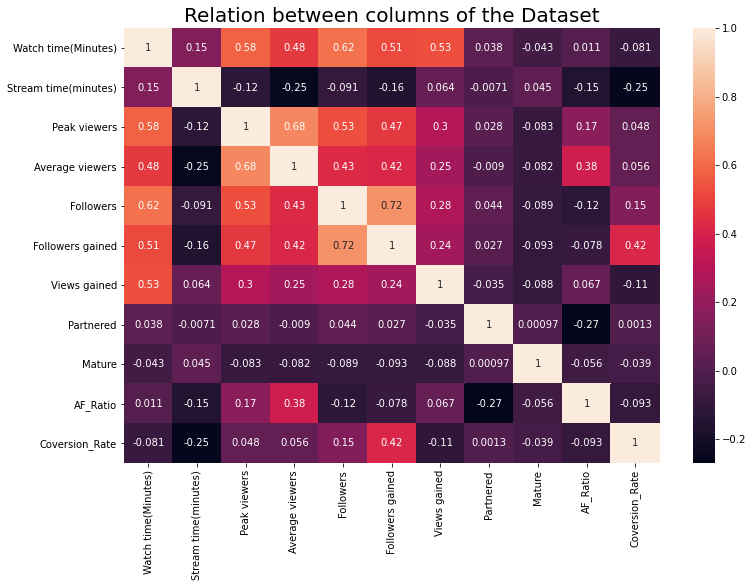

In [206]:
plt.figure(5, figsize=(12,8))
sns.heatmap(df.corr(), annot = True) #overall correlation between the various columns present in our data
plt.title('Relation between columns of the Dataset', fontsize = 20)
plt.show()

## Business Question: Which Language has the best potential? 